In [1]:
from astropy import units as u
import astropy.io.fits as fits
from astropy.coordinates import get_moon, get_sun, EarthLocation, SkyCoord
from astropy.table import vstack
from astropy.time import Time
from astropy.timeseries import TimeSeries, LombScargle
from astropy.stats import sigma_clip
from matplotlib import pyplot

from panoptes_client import Subject

import numpy
import pandas
import seaborn
import urllib

Broken libmagic installation detected. The python-magic module is installed but can't be imported. Please check that both python-magic and the libmagic shared library are installed correctly. Uploading media other than images may not work.


In [2]:
SWASP_ID = 74205318
FOLDING_PERIOD = 0 # Days. Set to 0 to run Lomb-Scargle
AUTO_FOLDED_PLOTS = 10 # How many of the top Lomb-Scargle periods to plot
PERIOD_MAX_DAYS = 600 # Max for Lomb-Scargle
PERIOD_MIN_DAYS = 1.0/24.0 # Min for Lomb-Scargle
SIGMA_CLIP = 4
START_TIME = 0 # Will be automatically overridden for BHH subjects
END_TIME = 0 # Will be automatically overridden for BHH subjects
VESPA_EXPORT = '../../superwasp-data/vespa-export.csv' # Set to None to skip loading superwasp.org FITS URLs

In [3]:
if type(SWASP_ID) is int:
    subject = Subject(SWASP_ID)
    if 'wasp_id' in subject.metadata:
        SWASP_ID = subject.metadata['wasp_id']
    if '#start_tmid' in subject.metadata:
        START_TIME = subject.metadata['#start_tmid']
    if '#end_tmid' in subject.metadata:
        END_TIME = subject.metadata['#end_tmid']

In [4]:
TARGET_COORD = SkyCoord.from_name(SWASP_ID, parse=True)

In [5]:
if VESPA_EXPORT is not None:
    vespa = pandas.read_csv(VESPA_EXPORT)
    fits_urls = vespa[vespa['SuperWASP ID'] == SWASP_ID.replace(' ', '')]['FITS URL'].unique()
else:
    fits_urls = []

In [6]:
if len(fits_urls) == 0:
    fits_url = 'http://wasp.warwick.ac.uk/lcextract?{}'.format(
        urllib.parse.urlencode(
            {'objid': SWASP_ID.replace('1SWASPJ', '1SWASP J')},
            quote_via=urllib.parse.quote,
        )
    )
else:
    fits_url = fits_urls[0]
fits_url

'http://wasp.warwick.ac.uk/lcextract?objid=1SWASP%20J192345.86-760855.0'

In [7]:
f2mag = lambda f: 15 - 2.5 * numpy.log10(f)
superwasp_n_location = EarthLocation.of_site("Roque de los Muchachos")
superwasp_s_location = EarthLocation.of_site("Sutherland")

superwasp_locations = {1: superwasp_n_location, 2: superwasp_s_location}
def lunar_phase(times, location):
    moon_coords = get_moon(
            time=times,
            location=location,
    )
    return (
        moon_coords.separation(get_sun(time=times)),
        moon_coords.separation(TARGET_COORD),
    )

In [8]:
fits_file = fits.open(fits_url)
hjd_col = fits.Column(name='HJD', format='D', array=fits_file[1].data['TMID'] / 86400 + 2453005.5)
lc_data = fits.BinTableHDU.from_columns(fits_file[1].data.columns + fits.ColDefs([hjd_col]))
timeseries = TimeSeries.read(lc_data, time_column='HJD', time_format='jd')

In [9]:
timeseries['location ID'] = [int(s[0]) for s in timeseries['IMAGEID']]
ts_parts = []
for id, loc in superwasp_locations.items():
    loc_ts = timeseries[timeseries['location ID'] == id]
    if len(loc_ts) == 0:
        continue
    loc_ts['lunar phase'], loc_ts['lunar separation'] = lunar_phase(loc_ts.time, loc)
    ts_parts.append(loc_ts)
timeseries = vstack(ts_parts)

In [10]:
if SIGMA_CLIP > 0:
    ts_flux = sigma_clip(timeseries['TAMFLUX2'], sigma=SIGMA_CLIP)
else:
    ts_flux = timeseries['TAMFLUX2']
ts_data = {
    'time': timeseries.time.jd,
    'flux': ts_flux,
    'err': timeseries['TAMFLUX2_ERR'],
    'camera': timeseries['CAMERA_ID'],
    'lunar phase': timeseries['lunar phase'],
    'lunar separation': timeseries['lunar separation'],
}

In [11]:
def get_folded_ts(orig_ts, period):
    ts = orig_ts.fold(period=period * 86400 * u.second)
    epoch_length = ts['time'].max() - ts['time'].min()
    ts_out = [ts]
    ts_new = ts.copy()
    ts_new['time'] = ts_new['time'] + epoch_length
    ts_out.append(ts_new)
    ts = vstack(ts_out)
    if SIGMA_CLIP > 0:
        ts_flux = sigma_clip(ts['TAMFLUX2'], sigma=SIGMA_CLIP)
    else:
        ts_flux = ts['TAMFLUX2']

    return {
        'time': ts.time.jd,
        'flux': ts_flux,
        'err': ts['TAMFLUX2_ERR'],
        'camera': ts['CAMERA_ID'],
        'lunar phase': ts['lunar phase'],
        'lunar separation': ts['lunar separation'],
    }

In [12]:
trimmed_timeseries = timeseries
if START_TIME > 0:
    START_TIME = Time(START_TIME / 86400 + 2453005.5, format='jd')
    trimmed_timeseries = trimmed_timeseries[trimmed_timeseries['time'] > START_TIME]
if END_TIME > 0:
    END_TIME = Time(END_TIME / 86400 + 2453005.5, format='jd')
    trimmed_timeseries = trimmed_timeseries[trimmed_timeseries['time'] < END_TIME]


C:\Users\anm83\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


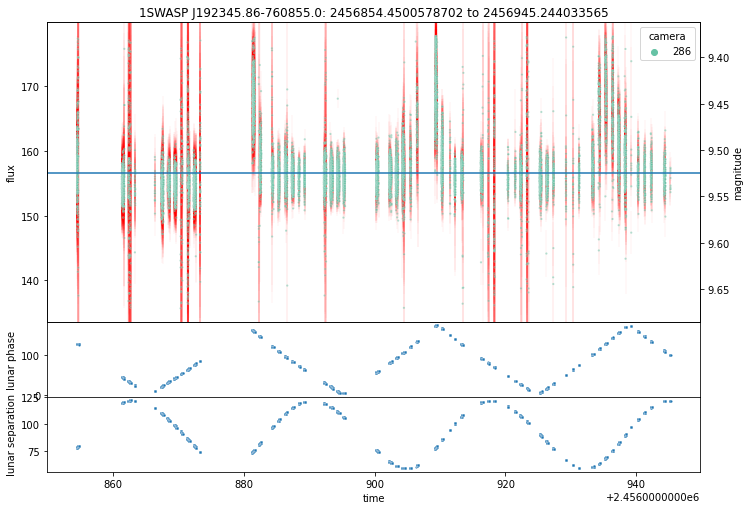

In [13]:
if trimmed_timeseries is not timeseries:
    if SIGMA_CLIP > 0:
        trimmed_ts_flux = sigma_clip(trimmed_timeseries['TAMFLUX2'], sigma=SIGMA_CLIP)
    else:
        trimmed_ts_flux = trimmed_timeseries['TAMFLUX2']
    trimmed_ts_data = {
        'time': trimmed_timeseries.time.jd,
        'flux': trimmed_ts_flux,
        'err': trimmed_timeseries['TAMFLUX2_ERR'],
        'camera': trimmed_timeseries['CAMERA_ID'],
        'lunar phase': trimmed_timeseries['lunar phase'],
        'lunar separation': trimmed_timeseries['lunar separation'],
    }

    f, (main_ax, lunar_phase_ax, lunar_sep_ax) = pyplot.subplots(
        3, 1, figsize=(11.7,8.27), sharex='col', gridspec_kw={'height_ratios': (4, 1, 1)}
    )

    seaborn.scatterplot(
        data=trimmed_ts_data,
        x='time',
        y='flux',
        alpha=0.5,
        s=5,
        palette='Set2',
        hue='camera',
        ax=main_ax,
    )

    lims = main_ax.get_ylim()
    main_ax.axhline(numpy.median(trimmed_ts_flux))

    main_ax.errorbar(
        trimmed_ts_data['time'], trimmed_ts_data['flux'], yerr=trimmed_ts_data['err'], 
        ecolor='red', ls='none', zorder=-1, alpha=0.5, elinewidth=0.1
    )

    main_ax.set_ylim(lims)
    main_ax_right = main_ax.twinx()
    main_ax_right.set_ylim(f2mag(lims[0]), f2mag(lims[1]))
    main_ax_right.set_ylabel('magnitude')

    seaborn.scatterplot(
        data=trimmed_ts_data,
        x='time',
        y='lunar phase',
        s=5,
        palette='Set2',
        ax=lunar_phase_ax,
    )

    seaborn.scatterplot(
        data=trimmed_ts_data,
        x='time',
        y='lunar separation',
        s=5,
        palette='Set2',
        ax=lunar_sep_ax,
    )

    pyplot.subplots_adjust(hspace=.0)
    pyplot.title(f"{SWASP_ID}: {START_TIME} to {END_TIME}")

C:\Users\anm83\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Text(0.5, 1.0, '1SWASP J192345.86-760855.0')

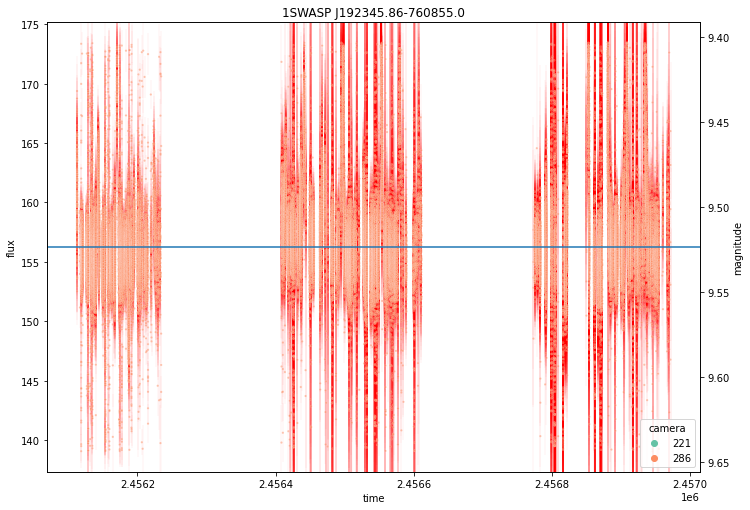

In [14]:
f, ax = pyplot.subplots(figsize=(11.7,8.27))
seaborn.scatterplot(
    data=ts_data,
    x='time',
    y='flux',
    alpha=0.5,
    s=5,
    palette='Set2',
    hue='camera',
)
lims = pyplot.ylim()
pyplot.axhline(numpy.median(ts_flux))

pyplot.errorbar(
    ts_data['time'], ts_data['flux'], yerr=ts_data['err'], 
    ecolor='red', ls='none', zorder=-1, alpha=0.5, elinewidth=0.1
)

pyplot.ylim(lims)
ax2 = ax.twinx()
ax2.set_ylim(f2mag(lims[0]), f2mag(lims[1]))
ax2.set_ylabel('magnitude')
pyplot.title(SWASP_ID)

In [15]:
if FOLDING_PERIOD == 0:
    frequency, power = LombScargle(ts_data['time'], ts_data['flux'], ts_data['err']).autopower()
    periods = pandas.DataFrame({'frequency': frequency, 'power': power, 'period': 1/frequency}).sort_values('power', ascending=False)
else:
    ls = None
    periods = pandas.DataFrame({'frequency': 1, 'power': [1], 'period': FOLDING_PERIOD})
periods

frequency         power     period
340      0.036514  1.750347e-02  27.386588
341      0.036621  1.703634e-02  27.306393
339      0.036407  1.639372e-02  27.467255
342      0.036729  1.507681e-02  27.226666
9009     0.966152  1.473148e-02   1.035033
...           ...           ...        ...
474905  50.927477  5.167836e-10   0.019636
359002  38.498378  4.206435e-10   0.025975
334165  35.834931  4.142012e-10   0.027906
718967  77.099971  3.320044e-10   0.012970
95663   10.258674  5.282784e-11   0.097478

[1027188 rows x 3 columns]

In [16]:
periods['period'] = numpy.round(periods['period'], 1)
periods = periods.drop_duplicates(subset=('period',))
periods = periods[periods['period'] <= PERIOD_MAX_DAYS ]
periods = periods[periods['period'] >= PERIOD_MIN_DAYS ]
periods

frequency         power  period
340    0.036514  1.750347e-02    27.4
341    0.036621  1.703634e-02    27.3
339    0.036407  1.639372e-02    27.5
342    0.036729  1.507681e-02    27.2
9009   0.966152  1.473148e-02     1.0
...         ...           ...     ...
179    0.019249  2.327209e-05    52.0
106    0.011421  1.771540e-05    87.6
107    0.011528  7.631282e-06    86.7
259    0.027828  4.195784e-06    35.9
63     0.006810  6.510624e-07   146.9

[594 rows x 3 columns]

[None]

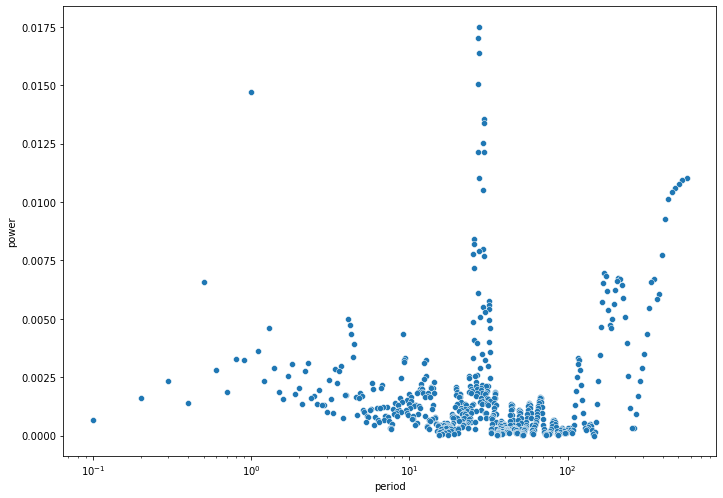

In [17]:
f, ax = pyplot.subplots(figsize=(11.7,8.27))
seaborn.scatterplot(data=periods, x='period', y='power').set(xscale="log")

C:\Users\anm83\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


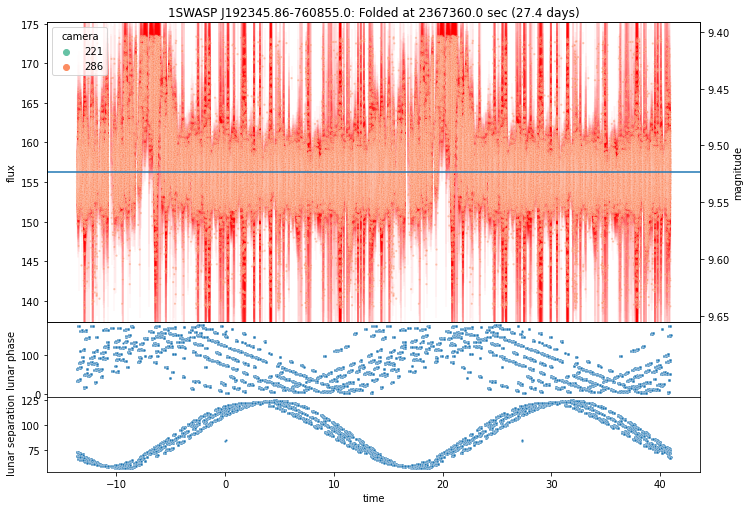

C:\Users\anm83\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


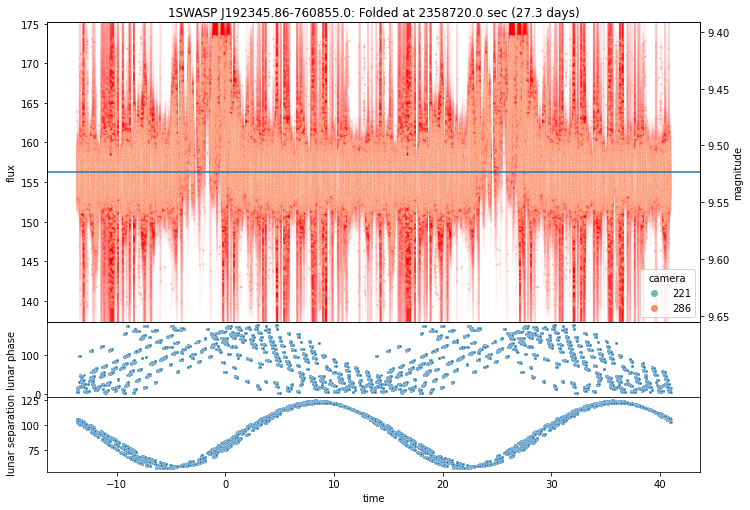

C:\Users\anm83\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


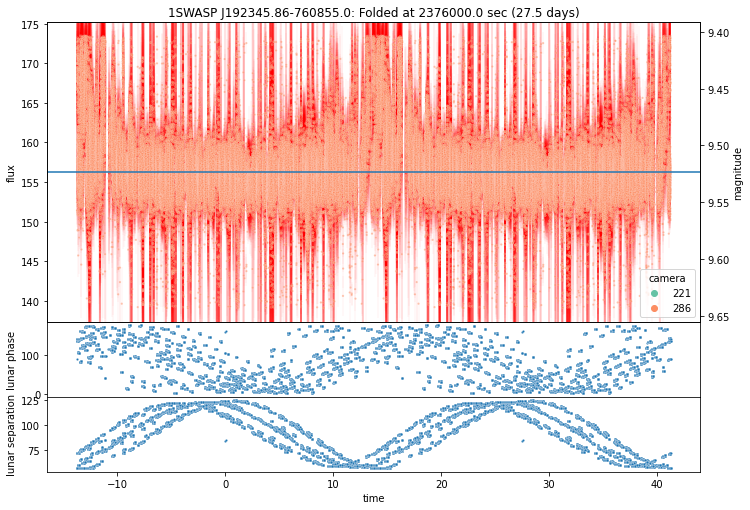

C:\Users\anm83\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


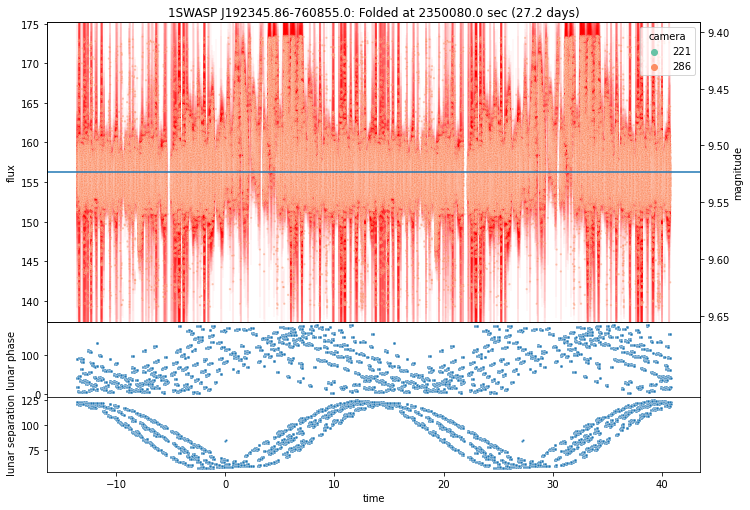

C:\Users\anm83\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


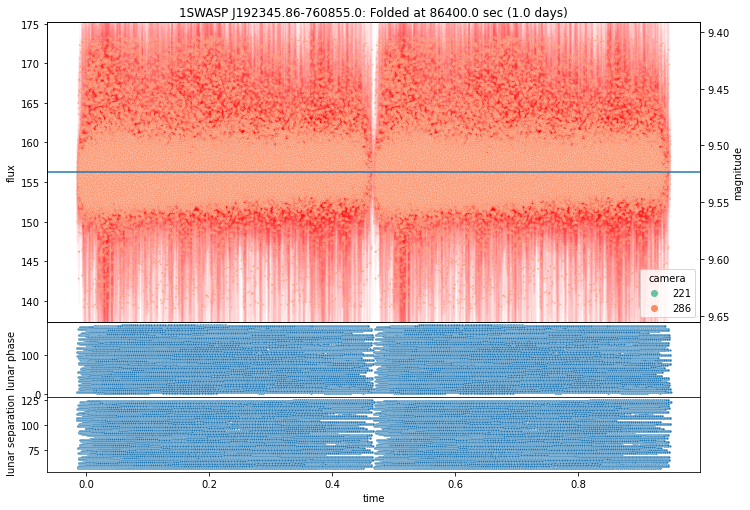

C:\Users\anm83\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


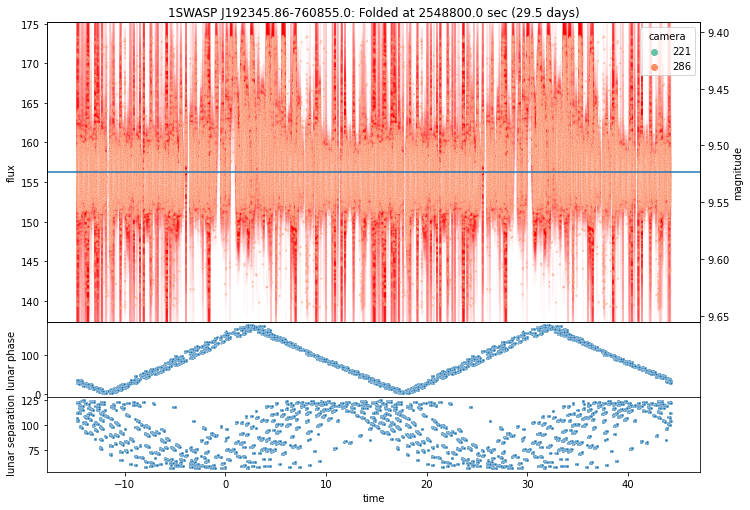

C:\Users\anm83\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


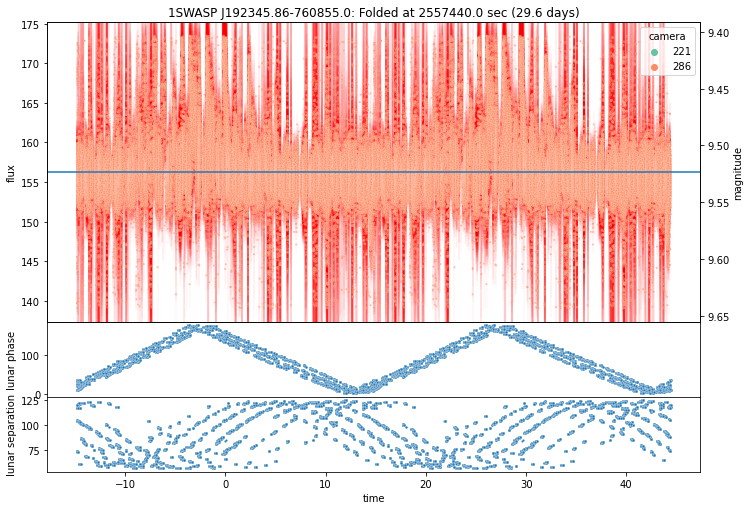

C:\Users\anm83\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


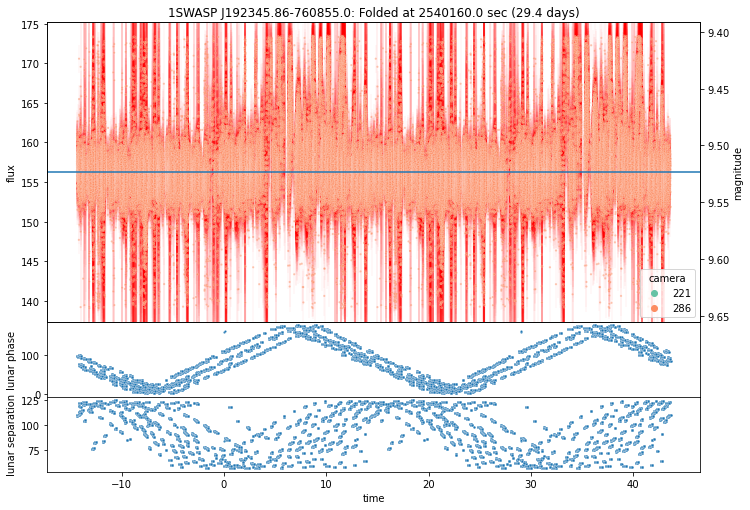

C:\Users\anm83\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
C:\Users\anm83\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


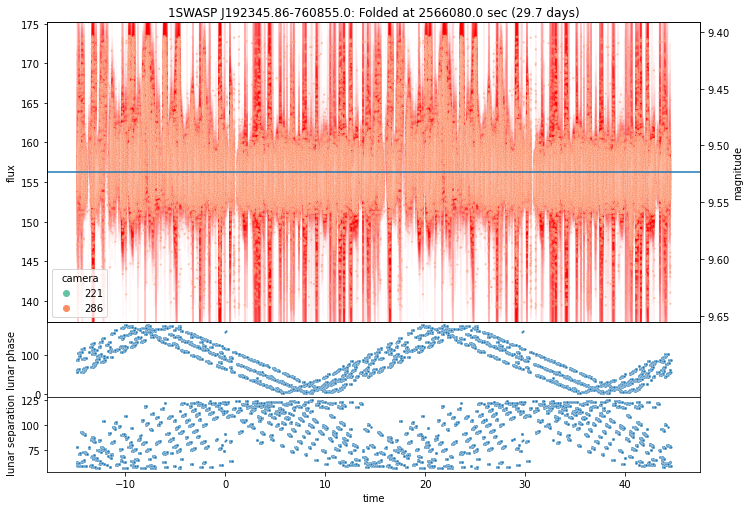

C:\Users\anm83\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


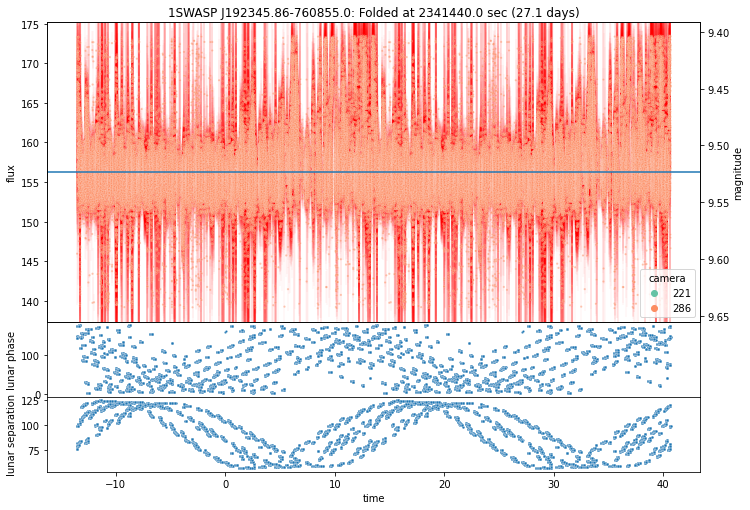

In [18]:
for i, period_row in periods.head(AUTO_FOLDED_PLOTS).iterrows():
    period = period_row['period']
    folded_ts_data = get_folded_ts(timeseries, period)

    f, (main_ax, lunar_phase_ax, lunar_sep_ax) = pyplot.subplots(
        3, 1, figsize=(11.7,8.27), sharex='col', gridspec_kw={'height_ratios': (4, 1, 1)}
    )

    seaborn.scatterplot(
        data=folded_ts_data,
        x='time',
        y='flux',
        alpha=0.5,
        s=5,
        palette='Set2',
        hue='camera',
        ax=main_ax,
    )

    lims = main_ax.get_ylim()
    main_ax.axhline(numpy.median(folded_ts_data['flux']))

    main_ax.errorbar(
        folded_ts_data['time'], folded_ts_data['flux'], yerr=folded_ts_data['err'], 
        ecolor='red', ls='none', zorder=-1, alpha=0.5, elinewidth=0.1
    )

    main_ax.set_ylim(lims)
    main_ax_right = main_ax.twinx()
    main_ax_right.set_ylim(f2mag(lims[0]), f2mag(lims[1]))
    main_ax_right.set_ylabel('magnitude')

    seaborn.scatterplot(
        data=folded_ts_data,
        x='time',
        y='lunar phase',
        s=5,
        palette='Set2',
        ax=lunar_phase_ax,
    )

    seaborn.scatterplot(
        data=folded_ts_data,
        x='time',
        y='lunar separation',
        s=5,
        palette='Set2',
        ax=lunar_sep_ax,
    )

    pyplot.subplots_adjust(hspace=.0)
    pyplot.title(f'{SWASP_ID}: Folded at {period * 86400} sec ({period} days)')
    pyplot.show()